# Detecção de Bordas
Prof. Dr. Gustavo Resque  
MSc. Tiago Araújo

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display
from ipywidgets import *
import cv2

In [2]:
def get_ax(rows=1, cols=1):
    fig, axes = plt.subplots(figsize=(4,4), dpi = 100, nrows=rows, ncols=cols)
    if rows == 1 and cols == 1:
        axes.clear()
        axes.get_xaxis().set_visible(False)
        axes.get_yaxis().set_visible(False)
    else:
        for ax in axes:
            ax.clear()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    return axes

# Bordas

* Uma borda é uma transição rápida entre regiões claras e escuras de uma imagem
* O objetivo da detecção de bordas é identificar locais na imagem onde tais transições são fortes 
* Bordas fortes podem indicar características visual significantes de uma imagem, como os limites de um objeto, mudanças de textura e mudanças de profundidade

In [3]:
def generateimgcantos(block_size=20):
    
    preto = np.zeros((1,block_size), dtype=np.uint8)
    branco = np.zeros((1,block_size), dtype=np.uint8) + 255
    # 1/(1+e^(-x)) = sigmoid
    cinza = ( (1/(1+np.exp(-np.linspace(-6,6,block_size)))) * 255 ).reshape((1,block_size)).astype(np.uint8)
    
    img = np.zeros((5*block_size,5*block_size), dtype=np.uint8)
    img[:,0:block_size] = preto
    img[:,block_size:2*block_size] = cinza
    img[:,2*block_size:3*block_size] = branco
    img[:,3*block_size:4*block_size] = np.flip(cinza,1)
    img[:,4*block_size:5*block_size] = preto
    
    return img
    
def plotarDerivadasBordas():
    fig, axes = plt.subplots(figsize=(10,2), dpi = 100, nrows=1, ncols=4)
    axes[0].clear()
    axes[0].get_xaxis().set_visible(False)
    axes[0].get_yaxis().set_visible(False)
    plt.tight_layout()
    
#     dummy = np.zeros((256,256), dtype=np.uint8)
#     dummy[:] = np.linspace(0,255,256)
    img = generateimgcantos()
    
    linha = img[0,:]
    dydx = np.gradient(linha/255)
    d2ydx2 = np.gradient(dydx)
    
    axes[0].imshow(img,cmap='gray')
    axes[1].plot( linha/255/10 * 2 - 1./10)
    axes[2].plot(dydx ,color='red') # tentar colocar junto com o de cima (normalizar de algum jeito)
    axes[3].plot(d2ydx2/2, color='green', alpha=1)

<IPython.core.display.Javascript object>


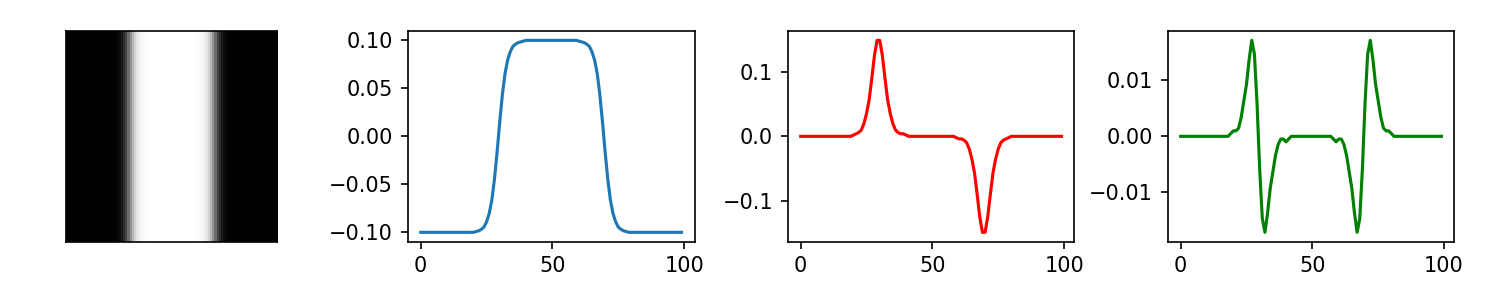

In [4]:
plotarDerivadasBordas()

# Aproximação digital do gradiente

* Para utilização do gradiente no campo discreto é necessário uma aprpximação
* Imagens digitais são discretas, não contínuas
* A aproximação do gradiente em um determinado local pode ser realizada calculando a mudança de intensidade horizontal e vertical

In [5]:
def get_ax(rows=1, cols=1,figsize=(4,4)):
    fig, axes = plt.subplots(figsize=figsize, dpi = 100, nrows=rows, ncols=cols)
    if rows == 1 and cols == 1:
        axes.clear()
        axes.get_xaxis().set_visible(False)
        axes.get_yaxis().set_visible(False)
    else:
        for ax in axes:
            ax.clear()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    return axes
     
def desenha_matriz(textarr, colors):
    txarr = textarr
    clrs = colors
    size = 100
    linewidth = size//100 if size//100 > 0 else 1

    im = np.zeros((txarr.shape[0]*size, txarr.shape[0]*size, 3), dtype=np.uint8)
    im[:,:] = (255,255,255)
    for i in range(txarr.shape[0]):
        for j in range(txarr.shape[1]):
            limx_start, limx_end = i*size, (i+1)*size
            limy_start, limy_end = j*size, (j+1)*size
            im[limx_start:limx_end, limy_start:limy_end] = clrs[i,j]
            
            cortext = 255 - clrs[i,j]
            cortext = cortext.astype(np.uint8)
            
            if len(txarr.shape) >= 3:
                cortext = (int(cortext[0]), int(cortext[1]), int(cortext[2]))
            else:
                cortext = (int(cortext), int(cortext), int(cortext))
            
            text = str(textarr[i,j])
            padding = 0 if len(text) == 1 else 2*len(text)
            
            cv2.putText(im, text, (limy_start + size//(3 + padding), (limx_start + size//2) + size//8),
                        cv2.FONT_HERSHEY_PLAIN, size//(30+padding), cortext, int(linewidth*2.5) , cv2.LINE_AA)

    for i in range(txarr.shape[0]):
        im[(i+1)*size-linewidth:linewidth+(i+1)*size,:,:] = 255 - im[(i+1)*size-linewidth:linewidth+(i+1)*size,:,:]
    for i in range(txarr.shape[1]):
        im[:,(i+1)*size-linewidth:linewidth+(i+1)*size,:] = 255 - im[:,(i+1)*size-linewidth:linewidth+(i+1)*size,:]
            
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [6]:
sobelX = np.array([
[-1,0,1],
[-2,0,2],
[-1,0,1]
], dtype=np.int)

sobelY = np.transpose(np.flip(sobelX,1))

laplacekernel = np.array([
[0, 1, 0],
[1,-4,1],
[0, 1, 0]
], dtype=np.int)

gradientkernel = np.array([
['Aue','Au','Aud'],
['Ae','Act','Ad'],
['Abe','Ab','Abd']
], dtype=np.str)

cores1 = np.array([
[255,255,255],
[255, 0 ,255],
[255,255,255]
], dtype=np.uint8)

cores2 = np.array([
[255,255,255],
[255,255,255],
[255,255,255]
], dtype=np.uint8)

coresX = np.array([
[255,200,255],
[255,200,255],
[255,200,255]
], dtype=np.uint8)

coresY = np.array([
[255,255,255],
[200,200,200],
[255,255,255]
], dtype=np.uint8)

coresgrad = np.array([
[200,255,200],
[255,255,255],
[200,255,200]
], dtype=np.uint8)

\begin{equation*}
    \nabla I(x,y)=\bigl(\begin{smallmatrix}
    \delta I(x,y)/\delta x \\ 
    \delta I(x,y)/ \delta y \\
    \end{smallmatrix}\bigr)
    \simeq \bigl(\begin{smallmatrix}
    Ad - Ae\\ 
    Ab - Au
    \end{smallmatrix}\bigr)
\end{equation*}

<IPython.core.display.Javascript object>


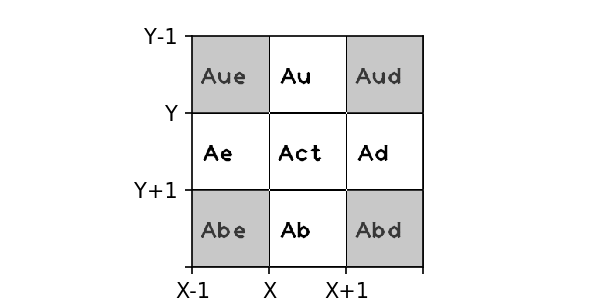

In [7]:
axes = get_ax(1,1, (4,2))
axes.get_xaxis().set_visible(True)
axes.get_yaxis().set_visible(True)
axes.set_xticklabels(['','X-1','X','X+1',''])
axes.set_yticklabels(['','Y-1','Y','Y+1'])
axes.imshow(desenha_matriz(gradientkernel,coresgrad))

# Operador Sobel

* O operador sobel é uma opção para aproximação que suprime ruído 
* Destaca as bordas dando ênfase para elementos chaves

<IPython.core.display.Javascript object>


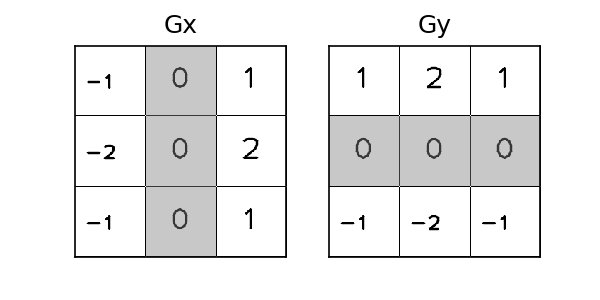

In [8]:
axes = get_ax(1,2, (4,2))
axes[0].set_title('Gx')
axes[0].imshow(desenha_matriz(sobelX,coresX))
axes[1].set_title('Gy')
axes[1].imshow(desenha_matriz(sobelY,coresY))

In [9]:
def sobelBordas(caminho):
    fig, axes = plt.subplots(1,4,figsize=(8,2), dpi = 100)
    img = cv2.imread(caminho,0)
    delta = 0
    ddepth = cv2.CV_16S
    
    def update(args):
        for ax in axes:
            ax.clear()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        gradient_x = cv2.Sobel(img, ddepth, 1, 0, ksize=slider.value, scale=slider_scale.value, delta=delta, borderType=cv2.BORDER_DEFAULT)
        gradient_y = cv2.Sobel(img, ddepth, 0, 1, ksize=slider.value, scale=slider_scale.value, delta=delta, borderType=cv2.BORDER_DEFAULT)
        #cv2.filter2D - aplicar convolução
        
        abs_grad_x = cv2.convertScaleAbs(gradient_x)
        abs_grad_y = cv2.convertScaleAbs(gradient_y)

        gradient = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

        axes[0].imshow(img, cmap='gray')
        axes[0].set_title('Original')
        axes[1].imshow(abs_grad_x, cmap='gray')    
        axes[1].set_title('Gradiente X')
        axes[2].imshow(abs_grad_y, cmap='gray')
        axes[2].set_title('Gradiente Y')        
        axes[3].imshow(gradient, cmap='gray')
        axes[3].set_title('Gradiente Total')
    
    slider = IntSlider(min=1,max=9,step=2,value=3,description='Tam Kernel')
    slider.observe(update, names='value')
    display(slider)
    
    slider_scale = FloatSlider(min=-1,max=2,step=.2,value=1,description='Escala')
    slider_scale.observe(update, names='value')
    display(slider_scale)
    
    update({'new':3})

<IPython.core.display.Javascript object>


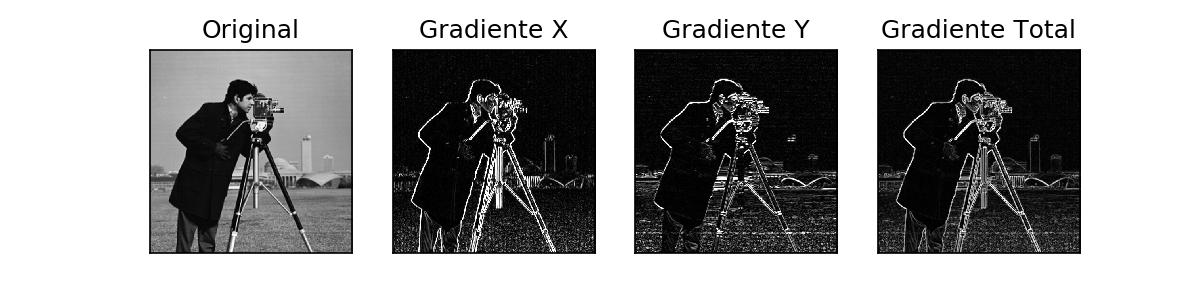

IntSlider(value=3, description='Tam Kernel', max=9, min=1, step=2)

FloatSlider(value=1.0, description='Escala', max=2.0, min=-1.0, step=0.2)

In [10]:
sobelBordas('dataset/cameraman.tif')

# Operador Laplace

* Baseado na segunda derivada
* Um pixel é considerado borda quando seu valor é zero

<IPython.core.display.Javascript object>


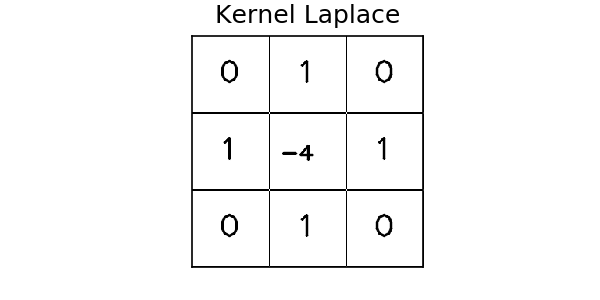

In [11]:
axes = get_ax(1,1, (4,2))
axes.set_title('Kernel Laplace')
axes.imshow(desenha_matriz(laplacekernel,cores2))

In [12]:
def laplaceBordas(caminho):
    fig, axes = plt.subplots(1,3,figsize=(8,2), dpi = 100)
    img = cv2.imread(caminho,0)
    ddepth = cv2.CV_16S
    slider = FloatSlider(min=1,max=20,step=1,value=1,description='Escala')

    def update(args):
        k_size = args['new']
        for ax in axes:
            ax.clear()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        
        gaussian = cv2.GaussianBlur(img,(5,5),3)
        dst = cv2.Laplacian(gaussian, ddepth, 3, scale=slider.value)
        abs_dst = cv2.convertScaleAbs(dst)
        
        axes[0].imshow(img, cmap='gray')
        axes[0].set_title('Original')
        axes[1].imshow(gaussian, cmap='gray')
        axes[1].set_title('Suavizada')
        axes[2].imshow((10 * abs_dst), cmap='gray')
        axes[2].set_title('Laplace')

    update({'new':1})
    slider.observe(update, names='value')
    display(slider)

<IPython.core.display.Javascript object>


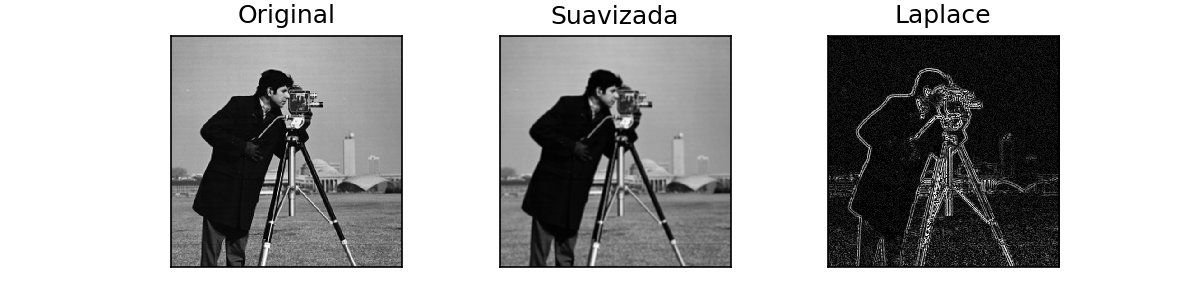

FloatSlider(value=1.0, description='Escala', max=20.0, min=1.0, step=1.0)

In [13]:
laplaceBordas('dataset/cameraman.tif')